In [1]:
import argparse
import os
from typing import Tuple

import matplotlib.pyplot as plt

import gymnasium
import numpy as np
import pandas as pd
import torch
from tianshou.data import Batch, Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from torch.utils.tensorboard import SummaryWriter

from env.negotiation import NegotiationEnv
from env.negotiation import Outcome

In [2]:
def get_parser() -> argparse.ArgumentParser:
    parser = argparse.ArgumentParser()
    parser.add_argument("--seed", type=int, default=1626)
    parser.add_argument("--eps-test", type=float, default=0.05)
    parser.add_argument("--eps-train", type=float, default=0.1)
    parser.add_argument("--buffer-size", type=int, default=20000)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument(
        "--gamma", type=float, default=0.9, help="a smaller gamma favors earlier win"
    )
    parser.add_argument("--n-step", type=int, default=3)
    parser.add_argument("--target-update-freq", type=int, default=320)
    parser.add_argument("--epoch", type=int, default=20)
    parser.add_argument("--step-per-epoch", type=int, default=1000)
    parser.add_argument("--step-per-collect", type=int, default=10)
    parser.add_argument("--update-per-step", type=float, default=0.1)
    parser.add_argument("--batch-size", type=int, default=64)
    parser.add_argument(
        "--hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128]
    )
    parser.add_argument("--training-num", type=int, default=10)
    parser.add_argument("--test-num", type=int, default=10)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--render", type=float, default=0.1)
    parser.add_argument(
        "--win-rate",
        type=float,
        default=0.6,
        help="the expected winning rate: Optimal policy can get 0.7",
    )
    parser.add_argument(
        "--watch",
        default=False,
        action="store_true",
        help="no training, " "watch the play of pre-trained models",
    )
    parser.add_argument(
        "--agent-id",
        type=int,
        default=2,
        help="the learned agent plays as the"
        " agent_id-th player. Choices are 1 and 2.",
    )
    parser.add_argument(
        "--resume-path",
        type=str,
        default="",
        help="the path of agent pth file " "for resuming from a pre-trained agent",
    )
    parser.add_argument(
        "--opponent-path",
        type=str,
        default="",
        help="the path of opponent agent pth file "
        "for resuming from a pre-trained agent",
    )
    parser.add_argument(
        "--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu"
    )
    return parser


def get_args() -> argparse.Namespace:
    parser = get_parser()
    return parser.parse_known_args()[0]


def get_agents(
    args: argparse.Namespace = get_args(),
    stakeholder_vals: np.ndarray | None = None
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = get_env(stakeholder_vals)
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gymnasium.spaces.Dict)
        else env.observation_space
    )
    args.state_shape = observation_space.shape or observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n


    agents = []
    for _ in range(env.env.n_agents):
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device,
        ).to(args.device)
        optim = torch.optim.Adam(net.parameters(), lr=args.lr)

        agents.append(DQNPolicy(net, optim, args.gamma, args.n_step, target_update_freq=args.target_update_freq))
    policy = MultiAgentPolicyManager(agents, env)
    return policy, env.agents


def get_env(data=None, render_mode=None, weights=None):
    return PettingZooEnv(NegotiationEnv(stakeholder_matrix=data, render_mode=render_mode, weights=weights))


def train_agent(
    args: argparse.Namespace = get_args(),
    stakeholder_vals: np.ndarray | None = None,
    weights = None
) -> Tuple[dict, BasePolicy]:
    # ======== environment setup =========
    train_envs = DummyVectorEnv([lambda: get_env(stakeholder_vals, weights=weights) for _ in range(args.training_num)])
    test_envs = DummyVectorEnv([lambda: get_env(stakeholder_vals, weights=weights) for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)

    # ======== agent setup =========
    policy, agents = get_agents(args, stakeholder_vals)

    # ======== collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(args.buffer_size, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    train_collector.collect(n_step=args.batch_size * args.training_num)

    # ======== tensorboard logging setup =========
    log_path = os.path.join(args.logdir, "negotiate", "dqn")
    writer = SummaryWriter(log_path)
    writer.add_text("args", str(args))
    logger = TensorboardLogger(writer)

    # ======== callback functions used during training =========
    def save_best_fn(policy):
        if hasattr(args, "model_save_path"):
            model_save_path = args.model_save_path
        else:
            model_save_path = os.path.join(
                args.logdir, "negotiate", "dqn", "policy.pth"
            )
        torch.save(
            policy.policies[agents[args.agent_id - 1]].state_dict(), model_save_path
        )

    def stop_fn(mean_rewards):
        return mean_rewards >= args.win_rate

    def train_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_train)

    def test_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)

    def reward_metric(rews):
        return rews[:, args.agent_id - 1]

    # trainer
    result = offpolicy_trainer(
        policy,
        train_collector,
        test_collector,
        args.epoch,
        args.step_per_epoch,
        args.step_per_collect,
        args.test_num,
        args.batch_size,
        train_fn=train_fn,
        test_fn=test_fn,
        # stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=args.update_per_step,
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric
    )

    return result, policy.policies

In [4]:
metrics = []
actions = []

## TEST COALITION WEIGHTS
# data = pd.read_csv('data/coalition_weights.csv', header=None).values
# direct = np.arange(0,1.1,0.1)
# weight_name = "Coalition weight"

# for i in direct:
#     weights = {'direct': i, 'indirect':i}

## TEST POWER WEIGHTS
# data = pd.read_csv('data/power_weights.csv', header=None).values

# w_power = np.arange(1,11,1)
# cur_weights = w_power
# weight_name = "Power weight"

# for i in w_power:
#     weights = {"w_power":i}

## TEST POSITION WEIGHTS
# data = pd.read_csv('data/position_weights.csv', header=None).values

# w_position = np.arange(0,5.5,0.5)
# cur_weights = w_position
# weight_name = "Position weights"

# for i in w_position:
#     weights = {"w_position":i}

## TEST DISTANCE WEIGHTS
# data = pd.read_csv('data/distance_weights.csv', header=None).values

# w_distance = np.arange(0,35,5)
# cur_weights = w_distance
# weight_name = "Distance weights"

# for i in w_distance:
#     weights = {"w_distance":i}


## TEST PROB SUCCESS ALONE
data = pd.read_csv('data/prob_success_alone_weight.csv', header=None).values

prob_success_alone = np.arange(0,1.1,0.1)
cur_weights = prob_success_alone
weight_name = "Probability stakeholder with power, urgency, and legitimacy succeeds alone"

for i in prob_success_alone:
    weights = {"prob_success_alone":i}
####

    args = get_args()
    result, policies = train_agent(args, stakeholder_vals=data, weights=weights)

    env = get_env(data)
    obs, info = env.reset()
    done = False
    while not done:
        agent = env.env.agent_selection
        policy = policies[agent]
        action = policy.forward(batch=Batch(obs=[obs], info=[info])).act[0]
    
        recipient = f'agent_{action + 1}'
        # print(f'{agent} targeting {recipient}')
        # print(f'Actions: {env.env.agent_actions[agent]}')
        # print(env.env.observe(None))
        # print()
        
        obs, rew, done, truncated, info = env.step(action)
    metrics.append(env.env.infos['agent_1'])
    actions.append(env.env.agent_actions['agent_1'])
    print('Final state:')
    print(env.env.observe(None))
    env.close()

/Users/katherinehunter/Github/stakeholder-mapping/backend/env/negotiation.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  self.standardisation_factor = (2 * self.w_power + self.w_urgency
Epoch #1: 1001it [00:00, 1257.54it/s, agent_1/loss=316.311, agent_2/loss=331.510, agent_3/loss=520.093, agent_4/loss=268.047, agent_5/loss=0.032, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -544.300000 ± 348.137523, best_reward: -544.300000 ± 348.137523 in #1


Epoch #2: 1001it [00:00, 1854.56it/s, agent_1/loss=345.018, agent_2/loss=529.218, agent_3/loss=445.684, agent_4/loss=241.586, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -434.175000 ± 430.563149, best_reward: -434.175000 ± 430.563149 in #2


Epoch #3: 1001it [00:00, 1866.98it/s, agent_1/loss=489.083, agent_2/loss=494.020, agent_3/loss=536.780, agent_4/loss=309.501, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -578.625000 ± 336.792652, best_reward: -434.175000 ± 430.563149 in #2


Epoch #4: 1001it [00:00, 1868.73it/s, agent_1/loss=524.929, agent_2/loss=355.524, agent_3/loss=389.463, agent_4/loss=243.529, agent_5/loss=0.003, env_step=4000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #4: test_reward: -793.075000 ± 370.276688, best_reward: -434.175000 ± 430.563149 in #2


Epoch #5: 1001it [00:00, 1698.76it/s, agent_1/loss=613.072, agent_2/loss=505.277, agent_3/loss=302.510, agent_4/loss=271.676, agent_5/loss=0.000, env_step=5000, len=501, n/ep=0, n/st=10, rew=-172.23]


Epoch #5: test_reward: -709.925000 ± 279.557240, best_reward: -434.175000 ± 430.563149 in #2


Epoch #6: 1001it [00:00, 1853.54it/s, agent_1/loss=518.867, agent_2/loss=311.405, agent_3/loss=180.470, agent_4/loss=213.500, agent_5/loss=0.000, env_step=6000, len=501, n/ep=0, n/st=10, rew=-172.23]


Epoch #6: test_reward: -602.275000 ± 344.198098, best_reward: -434.175000 ± 430.563149 in #2


Epoch #7: 1001it [00:00, 1840.55it/s, agent_1/loss=458.928, agent_2/loss=620.320, agent_3/loss=137.369, agent_4/loss=297.923, agent_5/loss=0.002, env_step=7000, len=501, n/ep=0, n/st=10, rew=-172.23]


Epoch #7: test_reward: -387.275000 ± 436.074627, best_reward: -387.275000 ± 436.074627 in #7


Epoch #8: 1001it [00:00, 1856.06it/s, agent_1/loss=380.500, agent_2/loss=401.172, agent_3/loss=255.404, agent_4/loss=263.700, agent_5/loss=0.001, env_step=8000, len=501, n/ep=0, n/st=10, rew=-172.23]


Epoch #8: test_reward: 107.525000 ± 199.647860, best_reward: 107.525000 ± 199.647860 in #8


Epoch #9: 1001it [00:00, 1828.15it/s, agent_1/loss=519.162, agent_2/loss=479.380, agent_3/loss=251.408, agent_4/loss=264.600, agent_5/loss=0.000, env_step=9000, len=451, n/ep=0, n/st=10, rew=189.75]


Epoch #9: test_reward: 120.075000 ± 232.617713, best_reward: 120.075000 ± 232.617713 in #9


Epoch #10: 1001it [00:00, 1802.86it/s, agent_1/loss=498.248, agent_2/loss=335.957, agent_3/loss=269.898, agent_4/loss=210.010, agent_5/loss=0.002, env_step=10000, len=151, n/ep=0, n/st=10, rew=404.50]


Epoch #10: test_reward: 195.075000 ± 270.185771, best_reward: 195.075000 ± 270.185771 in #10


Epoch #11: 1001it [00:00, 1803.58it/s, agent_1/loss=566.911, agent_2/loss=284.346, agent_3/loss=210.711, agent_4/loss=267.557, agent_5/loss=0.002, env_step=11000, len=153, n/ep=0, n/st=10, rew=170.38]


Epoch #11: test_reward: 125.725000 ± 171.310042, best_reward: 195.075000 ± 270.185771 in #10


Epoch #12: 1001it [00:00, 1807.19it/s, agent_1/loss=504.537, agent_2/loss=535.079, agent_3/loss=235.305, agent_4/loss=324.589, agent_5/loss=0.001, env_step=12000, len=281, n/ep=0, n/st=10, rew=-40.25]


Epoch #12: test_reward: 7.600000 ± 252.624009, best_reward: 195.075000 ± 270.185771 in #10


Epoch #13: 1001it [00:00, 1735.16it/s, agent_1/loss=537.541, agent_2/loss=480.166, agent_3/loss=344.168, agent_4/loss=293.094, agent_5/loss=0.002, env_step=13000, len=331, n/ep=0, n/st=10, rew=206.50]


Epoch #13: test_reward: -32.675000 ± 419.227698, best_reward: 195.075000 ± 270.185771 in #10


Epoch #14: 1001it [00:00, 1715.45it/s, agent_1/loss=641.059, agent_2/loss=412.640, agent_3/loss=223.195, agent_4/loss=295.797, agent_5/loss=0.003, env_step=14000, len=481, n/ep=0, n/st=10, rew=84.25]


Epoch #14: test_reward: 16.350000 ± 357.794777, best_reward: 195.075000 ± 270.185771 in #10


Epoch #15: 1001it [00:00, 1795.22it/s, agent_1/loss=671.220, agent_2/loss=540.938, agent_3/loss=351.545, agent_4/loss=331.137, agent_5/loss=0.005, env_step=15000, len=206, n/ep=0, n/st=10, rew=374.00]


Epoch #15: test_reward: -87.700000 ± 374.370869, best_reward: 195.075000 ± 270.185771 in #10


Epoch #16: 1001it [00:00, 1525.25it/s, agent_1/loss=755.431, agent_2/loss=487.450, agent_3/loss=404.457, agent_4/loss=311.339, agent_5/loss=0.005, env_step=16000, len=331, n/ep=2, n/st=10, rew=26.37]


Epoch #16: test_reward: -10.700000 ± 383.082576, best_reward: 195.075000 ± 270.185771 in #10


Epoch #17: 1001it [00:00, 1679.31it/s, agent_1/loss=558.571, agent_2/loss=344.600, agent_3/loss=414.061, agent_4/loss=302.372, agent_5/loss=0.004, env_step=17000, len=181, n/ep=0, n/st=10, rew=-32.50]


Epoch #17: test_reward: 169.700000 ± 293.753506, best_reward: 195.075000 ± 270.185771 in #10


Epoch #18: 1001it [00:00, 1726.14it/s, agent_1/loss=563.558, agent_2/loss=424.796, agent_3/loss=229.502, agent_4/loss=379.999, agent_5/loss=0.003, env_step=18000, len=281, n/ep=0, n/st=10, rew=348.50]


Epoch #18: test_reward: 135.200000 ± 265.665104, best_reward: 195.075000 ± 270.185771 in #10


Epoch #19: 1001it [00:00, 1696.94it/s, agent_1/loss=621.038, agent_2/loss=529.397, agent_3/loss=225.358, agent_4/loss=357.795, agent_5/loss=0.003, env_step=19000, len=501, n/ep=1, n/st=10, rew=-136.75]


Epoch #19: test_reward: 325.150000 ± 207.786405, best_reward: 325.150000 ± 207.786405 in #19


Epoch #20: 1001it [00:00, 1723.59it/s, agent_1/loss=512.683, agent_2/loss=455.059, agent_3/loss=162.176, agent_4/loss=282.564, agent_5/loss=0.006, env_step=20000, len=121, n/ep=0, n/st=10, rew=540.00]


Epoch #20: test_reward: 248.475000 ± 209.712465, best_reward: 325.150000 ± 207.786405 in #19
Final state:
[[1 1 1 1 1]
 [1 1 1 1 0]
 [1 1 1 1 0]
 [1 1 1 1 1]
 [1 0 0 1 1]]


Epoch #1: 1001it [00:00, 1859.76it/s, agent_1/loss=429.917, agent_2/loss=370.354, agent_3/loss=377.775, agent_4/loss=444.516, agent_5/loss=0.033, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1037.700000 ± 194.455837, best_reward: -926.850000 ± 269.168864 in #0


Epoch #2: 1001it [00:00, 1824.28it/s, agent_1/loss=735.168, agent_2/loss=759.588, agent_3/loss=432.783, agent_4/loss=442.891, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -646.425000 ± 259.683920, best_reward: -646.425000 ± 259.683920 in #2


Epoch #3: 1001it [00:00, 1893.30it/s, agent_1/loss=803.989, agent_2/loss=575.419, agent_3/loss=529.620, agent_4/loss=412.545, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -772.625000 ± 202.166060, best_reward: -646.425000 ± 259.683920 in #2


Epoch #4: 1001it [00:00, 1796.47it/s, agent_1/loss=538.873, agent_2/loss=510.280, agent_3/loss=247.385, agent_4/loss=273.456, agent_5/loss=0.003, env_step=4000, len=451, n/ep=0, n/st=10, rew=-306.75]


Epoch #4: test_reward: 37.675000 ± 301.475104, best_reward: 37.675000 ± 301.475104 in #4


Epoch #5: 1001it [00:00, 1785.95it/s, agent_1/loss=269.003, agent_2/loss=628.225, agent_3/loss=140.074, agent_4/loss=317.255, agent_5/loss=0.001, env_step=5000, len=106, n/ep=0, n/st=10, rew=-10.50]


Epoch #5: test_reward: 80.950000 ± 107.029832, best_reward: 80.950000 ± 107.029832 in #5


Epoch #6: 1001it [00:00, 1548.11it/s, agent_1/loss=589.982, agent_2/loss=581.908, agent_3/loss=197.506, agent_4/loss=350.855, agent_5/loss=0.001, env_step=6000, len=26, n/ep=0, n/st=10, rew=-2.50]


Epoch #6: test_reward: 221.925000 ± 156.207876, best_reward: 221.925000 ± 156.207876 in #6


Epoch #7: 1001it [00:00, 1702.77it/s, agent_1/loss=605.663, agent_2/loss=410.665, agent_3/loss=236.932, agent_4/loss=274.096, agent_5/loss=0.003, env_step=7000, len=46, n/ep=0, n/st=10, rew=-4.50]


Epoch #7: test_reward: 197.425000 ± 101.110586, best_reward: 221.925000 ± 156.207876 in #6


Epoch #8: 1001it [00:00, 1452.27it/s, agent_1/loss=604.788, agent_2/loss=537.123, agent_3/loss=192.244, agent_4/loss=278.363, agent_5/loss=0.004, env_step=8000, len=281, n/ep=0, n/st=10, rew=-90.75]


Epoch #8: test_reward: 204.150000 ± 141.347276, best_reward: 221.925000 ± 156.207876 in #6


Epoch #9: 1001it [00:01, 949.68it/s, agent_1/loss=522.736, agent_2/loss=543.982, agent_3/loss=317.074, agent_4/loss=340.603, agent_5/loss=0.005, env_step=9000, len=111, n/ep=0, n/st=10, rew=378.50]


Epoch #9: test_reward: 197.150000 ± 139.922800, best_reward: 221.925000 ± 156.207876 in #6


Epoch #10: 1001it [00:00, 1461.70it/s, agent_1/loss=345.110, agent_2/loss=581.797, agent_3/loss=306.236, agent_4/loss=412.344, agent_5/loss=0.006, env_step=10000, len=91, n/ep=0, n/st=10, rew=177.00]


Epoch #10: test_reward: 204.350000 ± 170.613020, best_reward: 221.925000 ± 156.207876 in #6


Epoch #11: 1001it [00:00, 1660.76it/s, agent_1/loss=522.963, agent_2/loss=783.804, agent_3/loss=258.057, agent_4/loss=205.833, agent_5/loss=0.008, env_step=11000, len=121, n/ep=0, n/st=10, rew=266.50]


Epoch #11: test_reward: 226.000000 ± 148.306440, best_reward: 226.000000 ± 148.306440 in #11


Epoch #12: 1001it [00:00, 1674.82it/s, agent_1/loss=444.870, agent_2/loss=745.265, agent_3/loss=360.332, agent_4/loss=418.202, agent_5/loss=0.008, env_step=12000, len=193, n/ep=2, n/st=10, rew=570.00]


Epoch #12: test_reward: 319.050000 ± 206.491459, best_reward: 319.050000 ± 206.491459 in #12


Epoch #13: 1001it [00:00, 1505.85it/s, agent_1/loss=425.071, agent_2/loss=728.558, agent_3/loss=387.334, agent_4/loss=365.758, agent_5/loss=0.009, env_step=13000, len=136, n/ep=0, n/st=10, rew=475.25]


Epoch #13: test_reward: 134.150000 ± 153.373286, best_reward: 319.050000 ± 206.491459 in #12


Epoch #14: 1001it [00:01, 986.64it/s, agent_1/loss=442.609, agent_2/loss=906.736, agent_3/loss=311.090, agent_4/loss=539.489, agent_5/loss=0.008, env_step=14000, len=331, n/ep=0, n/st=10, rew=122.00]


Epoch #14: test_reward: 263.475000 ± 195.270436, best_reward: 319.050000 ± 206.491459 in #12


Epoch #15: 1001it [00:00, 1397.53it/s, agent_1/loss=708.723, agent_2/loss=784.862, agent_3/loss=341.064, agent_4/loss=305.471, agent_5/loss=0.011, env_step=15000, len=71, n/ep=0, n/st=10, rew=356.75]


Epoch #15: test_reward: 269.575000 ± 180.948924, best_reward: 319.050000 ± 206.491459 in #12


Epoch #16: 1001it [00:00, 1351.78it/s, agent_1/loss=500.872, agent_2/loss=759.758, agent_3/loss=290.065, agent_4/loss=373.547, agent_5/loss=0.009, env_step=16000, len=131, n/ep=0, n/st=10, rew=352.00]


Epoch #16: test_reward: 333.450000 ± 208.013635, best_reward: 333.450000 ± 208.013635 in #16


Epoch #17: 1001it [00:00, 1445.33it/s, agent_1/loss=618.338, agent_2/loss=729.190, agent_3/loss=376.354, agent_4/loss=407.035, agent_5/loss=0.011, env_step=17000, len=196, n/ep=0, n/st=10, rew=-19.50]


Epoch #17: test_reward: 263.875000 ± 257.278236, best_reward: 333.450000 ± 208.013635 in #16


Epoch #18: 1001it [00:00, 1454.88it/s, agent_1/loss=509.473, agent_2/loss=770.118, agent_3/loss=363.348, agent_4/loss=491.286, agent_5/loss=0.009, env_step=18000, len=161, n/ep=0, n/st=10, rew=439.25]


Epoch #18: test_reward: 185.350000 ± 222.971192, best_reward: 333.450000 ± 208.013635 in #16


Epoch #19: 1001it [00:00, 1663.27it/s, agent_1/loss=717.730, agent_2/loss=619.911, agent_3/loss=412.672, agent_4/loss=560.876, agent_5/loss=0.010, env_step=19000, len=131, n/ep=0, n/st=10, rew=366.25]


Epoch #19: test_reward: 333.450000 ± 208.013635, best_reward: 333.450000 ± 208.013635 in #16


Epoch #20: 1001it [00:00, 1409.29it/s, agent_1/loss=643.906, agent_2/loss=561.348, agent_3/loss=371.254, agent_4/loss=478.611, agent_5/loss=0.014, env_step=20000, len=103, n/ep=2, n/st=10, rew=210.75]


Epoch #20: test_reward: 464.875000 ± 242.293578, best_reward: 464.875000 ± 242.293578 in #20
Final state:
[[1 1 0 1 1]
 [1 1 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1472.16it/s, agent_1/loss=772.767, agent_2/loss=705.664, agent_3/loss=633.760, agent_4/loss=457.081, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -916.400000 ± 267.241796, best_reward: -916.400000 ± 267.241796 in #1


Epoch #2: 1001it [00:00, 1849.09it/s, agent_1/loss=959.278, agent_2/loss=758.813, agent_3/loss=602.212, agent_4/loss=576.430, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1010.525000 ± 128.329773, best_reward: -916.400000 ± 267.241796 in #1


Epoch #3: 1001it [00:00, 1879.71it/s, agent_1/loss=641.017, agent_2/loss=704.948, agent_3/loss=402.569, agent_4/loss=478.002, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -363.350000 ± 659.923056, best_reward: -363.350000 ± 659.923056 in #3


Epoch #4: 1001it [00:00, 1514.98it/s, agent_1/loss=372.186, agent_2/loss=1023.238, agent_3/loss=412.634, agent_4/loss=324.484, agent_5/loss=0.005, env_step=4000, len=61, n/ep=0, n/st=10, rew=-6.00]


Epoch #4: test_reward: 61.950000 ± 51.273507, best_reward: 61.950000 ± 51.273507 in #4


Epoch #5: 1001it [00:00, 1269.01it/s, agent_1/loss=497.667, agent_2/loss=935.678, agent_3/loss=420.741, agent_4/loss=466.838, agent_5/loss=0.004, env_step=5000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #5: test_reward: 97.800000 ± 81.034931, best_reward: 97.800000 ± 81.034931 in #5


Epoch #6: 1001it [00:00, 1508.45it/s, agent_1/loss=479.903, agent_2/loss=1052.359, agent_3/loss=739.843, agent_4/loss=471.572, agent_5/loss=0.002, env_step=6000, len=16, n/ep=1, n/st=10, rew=195.00]


Epoch #6: test_reward: 97.800000 ± 81.034931, best_reward: 97.800000 ± 81.034931 in #5


Epoch #7: 1001it [00:00, 1459.92it/s, agent_1/loss=412.894, agent_2/loss=1253.312, agent_3/loss=740.805, agent_4/loss=741.738, agent_5/loss=0.007, env_step=7000, len=31, n/ep=1, n/st=10, rew=220.00]


Epoch #7: test_reward: 97.800000 ± 81.034931, best_reward: 97.800000 ± 81.034931 in #5


Epoch #8: 1001it [00:00, 1660.84it/s, agent_1/loss=366.524, agent_2/loss=934.649, agent_3/loss=458.326, agent_4/loss=668.932, agent_5/loss=0.008, env_step=8000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #8: test_reward: 147.325000 ± 111.450889, best_reward: 147.325000 ± 111.450889 in #8


Epoch #9: 1001it [00:00, 1690.76it/s, agent_1/loss=397.571, agent_2/loss=958.231, agent_3/loss=525.534, agent_4/loss=525.273, agent_5/loss=0.009, env_step=9000, len=36, n/ep=0, n/st=10, rew=168.50]


Epoch #9: test_reward: 204.725000 ± 162.076658, best_reward: 204.725000 ± 162.076658 in #9


Epoch #10: 1001it [00:00, 1532.54it/s, agent_1/loss=338.839, agent_2/loss=877.634, agent_3/loss=601.891, agent_4/loss=676.436, agent_5/loss=0.012, env_step=10000, len=48, n/ep=2, n/st=10, rew=208.62]


Epoch #10: test_reward: 234.200000 ± 163.632660, best_reward: 234.200000 ± 163.632660 in #10


Epoch #11: 1001it [00:00, 1603.39it/s, agent_1/loss=419.971, agent_2/loss=684.372, agent_3/loss=545.245, agent_4/loss=679.703, agent_5/loss=0.027, env_step=11000, len=26, n/ep=0, n/st=10, rew=155.00]


Epoch #11: test_reward: 147.325000 ± 111.450889, best_reward: 234.200000 ± 163.632660 in #10


Epoch #12: 1001it [00:00, 1699.69it/s, agent_1/loss=501.239, agent_2/loss=608.142, agent_3/loss=745.933, agent_4/loss=481.709, agent_5/loss=0.022, env_step=12000, len=21, n/ep=1, n/st=10, rew=209.00]


Epoch #12: test_reward: 147.325000 ± 111.450889, best_reward: 234.200000 ± 163.632660 in #10


Epoch #13: 1001it [00:00, 1640.72it/s, agent_1/loss=463.260, agent_2/loss=798.858, agent_3/loss=848.077, agent_4/loss=520.053, agent_5/loss=0.020, env_step=13000, len=11, n/ep=0, n/st=10, rew=104.50]


Epoch #13: test_reward: 147.325000 ± 111.450889, best_reward: 234.200000 ± 163.632660 in #10


Epoch #14: 1001it [00:00, 1628.18it/s, agent_1/loss=380.429, agent_2/loss=805.341, agent_3/loss=966.409, agent_4/loss=580.347, agent_5/loss=0.023, env_step=14000, len=36, n/ep=0, n/st=10, rew=-3.50]


Epoch #14: test_reward: 147.325000 ± 111.450889, best_reward: 234.200000 ± 163.632660 in #10


Epoch #15: 1001it [00:00, 1004.89it/s, agent_1/loss=209.448, agent_2/loss=1122.104, agent_3/loss=1028.358, agent_4/loss=869.789, agent_5/loss=0.020, env_step=15000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #15: test_reward: 221.050000 ± 178.111089, best_reward: 234.200000 ± 163.632660 in #10


Epoch #16: 1001it [00:00, 1568.33it/s, agent_1/loss=250.346, agent_2/loss=980.647, agent_3/loss=876.027, agent_4/loss=706.553, agent_5/loss=0.021, env_step=16000, len=61, n/ep=0, n/st=10, rew=325.25]


Epoch #16: test_reward: 234.200000 ± 163.632660, best_reward: 234.200000 ± 163.632660 in #10


Epoch #17: 1001it [00:00, 1576.61it/s, agent_1/loss=180.740, agent_2/loss=915.846, agent_3/loss=943.229, agent_4/loss=965.336, agent_5/loss=0.034, env_step=17000, len=41, n/ep=0, n/st=10, rew=-4.00]


Epoch #17: test_reward: 204.725000 ± 162.076658, best_reward: 234.200000 ± 163.632660 in #10


Epoch #18: 1001it [00:00, 1707.48it/s, agent_1/loss=233.586, agent_2/loss=863.164, agent_3/loss=910.125, agent_4/loss=856.334, agent_5/loss=0.035, env_step=18000, len=101, n/ep=1, n/st=10, rew=89.25]


Epoch #18: test_reward: 223.225000 ± 182.351428, best_reward: 234.200000 ± 163.632660 in #10


Epoch #19: 1001it [00:00, 1684.07it/s, agent_1/loss=290.976, agent_2/loss=1149.420, agent_3/loss=831.118, agent_4/loss=767.110, agent_5/loss=0.031, env_step=19000, len=16, n/ep=0, n/st=10, rew=170.50]


Epoch #19: test_reward: 214.325000 ± 202.766462, best_reward: 234.200000 ± 163.632660 in #10


Epoch #20: 1001it [00:00, 1431.89it/s, agent_1/loss=259.736, agent_2/loss=989.343, agent_3/loss=770.188, agent_4/loss=859.180, agent_5/loss=0.028, env_step=20000, len=11, n/ep=1, n/st=10, rew=171.00]


Epoch #20: test_reward: 263.850000 ± 209.303822, best_reward: 263.850000 ± 209.303822 in #20
Final state:
[[1 0 0 0 1]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1337.57it/s, agent_1/loss=803.709, agent_2/loss=1056.976, agent_3/loss=817.635, agent_4/loss=728.474, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -996.125000 ± 170.765309, best_reward: -996.125000 ± 170.765309 in #1


Epoch #2: 1001it [00:00, 1536.91it/s, agent_1/loss=633.476, agent_2/loss=1058.518, agent_3/loss=620.330, agent_4/loss=514.831, agent_5/loss=0.001, env_step=2000, len=38, n/ep=0, n/st=10, rew=160.88]


Epoch #2: test_reward: 55.325000 ± 69.366243, best_reward: 55.325000 ± 69.366243 in #2


Epoch #3: 1001it [00:00, 1556.57it/s, agent_1/loss=537.121, agent_2/loss=1196.292, agent_3/loss=1076.094, agent_4/loss=898.463, agent_5/loss=0.000, env_step=3000, len=6, n/ep=1, n/st=10, rew=146.50]


Epoch #3: test_reward: 86.525000 ± 67.233218, best_reward: 86.525000 ± 67.233218 in #3


Epoch #4: 1001it [00:00, 1669.71it/s, agent_1/loss=382.859, agent_2/loss=1083.787, agent_3/loss=1270.344, agent_4/loss=774.221, agent_5/loss=0.006, env_step=4000, len=26, n/ep=0, n/st=10, rew=101.00]


Epoch #4: test_reward: 35.100000 ± 50.700986, best_reward: 86.525000 ± 67.233218 in #3


Epoch #5: 1001it [00:00, 1662.95it/s, agent_1/loss=387.721, agent_2/loss=860.141, agent_3/loss=1010.646, agent_4/loss=856.082, agent_5/loss=0.007, env_step=5000, len=1, n/ep=1, n/st=10, rew=0.00]


Epoch #5: test_reward: 78.650000 ± 70.400302, best_reward: 86.525000 ± 67.233218 in #3


Epoch #6: 1001it [00:00, 1538.01it/s, agent_1/loss=455.727, agent_2/loss=897.703, agent_3/loss=1047.368, agent_4/loss=871.158, agent_5/loss=0.009, env_step=6000, len=21, n/ep=1, n/st=10, rew=101.50]


Epoch #6: test_reward: 123.950000 ± 47.393275, best_reward: 123.950000 ± 47.393275 in #6


Epoch #7: 1001it [00:00, 1231.23it/s, agent_1/loss=533.507, agent_2/loss=975.077, agent_3/loss=1115.467, agent_4/loss=806.598, agent_5/loss=0.014, env_step=7000, len=21, n/ep=0, n/st=10, rew=130.50]


Epoch #7: test_reward: 93.050000 ± 88.428629, best_reward: 123.950000 ± 47.393275 in #6


Epoch #8: 1001it [00:00, 1437.86it/s, agent_1/loss=380.665, agent_2/loss=759.618, agent_3/loss=1171.756, agent_4/loss=743.494, agent_5/loss=0.014, env_step=8000, len=11, n/ep=0, n/st=10, rew=150.88]


Epoch #8: test_reward: 161.650000 ± 124.948499, best_reward: 161.650000 ± 124.948499 in #8


Epoch #9: 1001it [00:00, 1657.63it/s, agent_1/loss=366.470, agent_2/loss=756.465, agent_3/loss=1397.923, agent_4/loss=809.749, agent_5/loss=0.012, env_step=9000, len=56, n/ep=0, n/st=10, rew=182.25]


Epoch #9: test_reward: 161.650000 ± 124.948499, best_reward: 161.650000 ± 124.948499 in #8


Epoch #10: 1001it [00:00, 1672.03it/s, agent_1/loss=374.146, agent_2/loss=725.255, agent_3/loss=1520.215, agent_4/loss=1038.619, agent_5/loss=0.020, env_step=10000, len=6, n/ep=1, n/st=10, rew=146.50]


Epoch #10: test_reward: 161.650000 ± 124.948499, best_reward: 161.650000 ± 124.948499 in #8


Epoch #11: 1001it [00:00, 1630.16it/s, agent_1/loss=363.344, agent_2/loss=963.857, agent_3/loss=1079.516, agent_4/loss=1717.175, agent_5/loss=0.026, env_step=11000, len=16, n/ep=1, n/st=10, rew=208.75]


Epoch #11: test_reward: 209.825000 ± 129.585110, best_reward: 209.825000 ± 129.585110 in #11


Epoch #12: 1001it [00:00, 1530.78it/s, agent_1/loss=472.151, agent_2/loss=955.902, agent_3/loss=1176.013, agent_4/loss=1588.897, agent_5/loss=0.021, env_step=12000, len=6, n/ep=1, n/st=10, rew=146.50]


Epoch #12: test_reward: 276.700000 ± 132.555592, best_reward: 276.700000 ± 132.555592 in #12


Epoch #13: 1001it [00:00, 1676.12it/s, agent_1/loss=490.872, agent_2/loss=878.930, agent_3/loss=1121.416, agent_4/loss=1418.019, agent_5/loss=0.023, env_step=13000, len=21, n/ep=0, n/st=10, rew=145.00]


Epoch #13: test_reward: 227.125000 ± 111.279785, best_reward: 276.700000 ± 132.555592 in #12


Epoch #14: 1001it [00:00, 1675.38it/s, agent_1/loss=374.452, agent_2/loss=867.159, agent_3/loss=1218.679, agent_4/loss=1408.183, agent_5/loss=0.029, env_step=14000, len=56, n/ep=0, n/st=10, rew=458.50]


Epoch #14: test_reward: 277.625000 ± 114.652423, best_reward: 277.625000 ± 114.652423 in #14


Epoch #15: 1001it [00:00, 1678.52it/s, agent_1/loss=366.014, agent_2/loss=974.210, agent_3/loss=988.580, agent_4/loss=1352.806, agent_5/loss=0.029, env_step=15000, len=16, n/ep=1, n/st=10, rew=399.25]


Epoch #15: test_reward: 188.825000 ± 120.382881, best_reward: 277.625000 ± 114.652423 in #14


Epoch #16: 1001it [00:00, 1670.78it/s, agent_1/loss=489.093, agent_2/loss=1088.012, agent_3/loss=1352.538, agent_4/loss=1286.501, agent_5/loss=0.028, env_step=16000, len=26, n/ep=0, n/st=10, rew=169.00]


Epoch #16: test_reward: 252.425000 ± 160.386644, best_reward: 277.625000 ± 114.652423 in #14


Epoch #17: 1001it [00:00, 1680.66it/s, agent_1/loss=692.574, agent_2/loss=1149.498, agent_3/loss=1522.925, agent_4/loss=1391.936, agent_5/loss=0.025, env_step=17000, len=41, n/ep=0, n/st=10, rew=245.25]


Epoch #17: test_reward: 406.800000 ± 115.730117, best_reward: 406.800000 ± 115.730117 in #17


Epoch #18: 1001it [00:00, 1683.76it/s, agent_1/loss=662.725, agent_2/loss=1210.697, agent_3/loss=1481.445, agent_4/loss=1408.270, agent_5/loss=0.024, env_step=18000, len=46, n/ep=0, n/st=10, rew=782.25]


Epoch #18: test_reward: -396.050000 ± 596.320822, best_reward: 406.800000 ± 115.730117 in #17


Epoch #19: 1001it [00:00, 1674.37it/s, agent_1/loss=728.191, agent_2/loss=1110.191, agent_3/loss=1512.370, agent_4/loss=1286.986, agent_5/loss=0.020, env_step=19000, len=26, n/ep=0, n/st=10, rew=-2.50]


Epoch #19: test_reward: 250.625000 ± 186.988845, best_reward: 406.800000 ± 115.730117 in #17


Epoch #20: 1001it [00:00, 1676.89it/s, agent_1/loss=875.424, agent_2/loss=1260.960, agent_3/loss=1323.698, agent_4/loss=1574.086, agent_5/loss=0.024, env_step=20000, len=36, n/ep=1, n/st=10, rew=383.00]


Epoch #20: test_reward: 351.100000 ± 201.458811, best_reward: 406.800000 ± 115.730117 in #17
Final state:
[[1 0 0 1 1]
 [0 1 1 0 0]
 [0 1 1 1 0]
 [1 0 1 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1778.86it/s, agent_1/loss=1113.457, agent_2/loss=1239.732, agent_3/loss=1013.674, agent_4/loss=737.553, agent_5/loss=0.027, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -947.425000 ± 185.093323, best_reward: -831.175000 ± 249.054764 in #0


Epoch #2: 1001it [00:00, 1792.44it/s, agent_1/loss=1139.182, agent_2/loss=1109.900, agent_3/loss=650.969, agent_4/loss=703.666, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -916.750000 ± 216.738610, best_reward: -831.175000 ± 249.054764 in #0


Epoch #3: 1001it [00:00, 1648.69it/s, agent_1/loss=1079.845, agent_2/loss=1417.457, agent_3/loss=1017.229, agent_4/loss=688.210, agent_5/loss=0.001, env_step=3000, len=26, n/ep=0, n/st=10, rew=155.00]


Epoch #3: test_reward: -215.150000 ± 594.449895, best_reward: -215.150000 ± 594.449895 in #3


Epoch #4: 1001it [00:00, 1697.97it/s, agent_1/loss=897.111, agent_2/loss=1908.490, agent_3/loss=1351.284, agent_4/loss=1183.923, agent_5/loss=0.006, env_step=4000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #4: test_reward: 169.625000 ± 48.587453, best_reward: 169.625000 ± 48.587453 in #4


Epoch #5: 1001it [00:00, 1681.54it/s, agent_1/loss=1145.320, agent_2/loss=1185.872, agent_3/loss=1059.824, agent_4/loss=1569.755, agent_5/loss=0.005, env_step=5000, len=31, n/ep=0, n/st=10, rew=154.50]


Epoch #5: test_reward: 133.225000 ± 87.869964, best_reward: 169.625000 ± 48.587453 in #4


Epoch #6: 1001it [00:00, 1680.05it/s, agent_1/loss=1339.960, agent_2/loss=1130.839, agent_3/loss=2245.406, agent_4/loss=1620.101, agent_5/loss=0.008, env_step=6000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #6: test_reward: 181.925000 ± 99.859529, best_reward: 181.925000 ± 99.859529 in #6


Epoch #7: 1001it [00:00, 1679.73it/s, agent_1/loss=1375.306, agent_2/loss=1227.722, agent_3/loss=1787.932, agent_4/loss=1943.610, agent_5/loss=0.010, env_step=7000, len=21, n/ep=0, n/st=10, rew=134.62]


Epoch #7: test_reward: 209.700000 ± 139.570314, best_reward: 209.700000 ± 139.570314 in #7


Epoch #8: 1001it [00:00, 1493.74it/s, agent_1/loss=1711.873, agent_2/loss=764.388, agent_3/loss=1417.696, agent_4/loss=1806.752, agent_5/loss=0.010, env_step=8000, len=16, n/ep=1, n/st=10, rew=377.75]


Epoch #8: test_reward: -228.750000 ± 607.305813, best_reward: 209.700000 ± 139.570314 in #7


Epoch #9: 1001it [00:00, 1695.80it/s, agent_1/loss=1842.870, agent_2/loss=1117.999, agent_3/loss=1501.870, agent_4/loss=1840.724, agent_5/loss=0.012, env_step=9000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #9: test_reward: -404.700000 ± 398.910012, best_reward: 209.700000 ± 139.570314 in #7


Epoch #10: 1001it [00:00, 1704.29it/s, agent_1/loss=1407.664, agent_2/loss=1043.266, agent_3/loss=1701.267, agent_4/loss=1985.501, agent_5/loss=0.012, env_step=10000, len=11, n/ep=1, n/st=10, rew=210.00]


Epoch #10: test_reward: 231.175000 ± 170.128189, best_reward: 231.175000 ± 170.128189 in #10


Epoch #11: 1001it [00:00, 1672.53it/s, agent_1/loss=886.050, agent_2/loss=781.518, agent_3/loss=1738.910, agent_4/loss=2435.401, agent_5/loss=0.013, env_step=11000, len=31, n/ep=0, n/st=10, rew=280.25]


Epoch #11: test_reward: 252.500000 ± 147.978884, best_reward: 252.500000 ± 147.978884 in #11


Epoch #12: 1001it [00:00, 1692.95it/s, agent_1/loss=1006.777, agent_2/loss=971.048, agent_3/loss=1716.586, agent_4/loss=2046.041, agent_5/loss=0.017, env_step=12000, len=28, n/ep=2, n/st=10, rew=-2.75]


Epoch #12: test_reward: 252.500000 ± 147.978884, best_reward: 252.500000 ± 147.978884 in #11


Epoch #13: 1001it [00:00, 1667.68it/s, agent_1/loss=845.062, agent_2/loss=1026.374, agent_3/loss=1673.275, agent_4/loss=1934.326, agent_5/loss=0.015, env_step=13000, len=41, n/ep=0, n/st=10, rew=475.00]


Epoch #13: test_reward: 252.500000 ± 147.978884, best_reward: 252.500000 ± 147.978884 in #11


Epoch #14: 1001it [00:00, 1547.86it/s, agent_1/loss=705.119, agent_2/loss=1229.902, agent_3/loss=1388.982, agent_4/loss=2082.673, agent_5/loss=0.013, env_step=14000, len=26, n/ep=0, n/st=10, rew=230.25]


Epoch #14: test_reward: 248.600000 ± 149.644378, best_reward: 252.500000 ± 147.978884 in #11


Epoch #15: 1001it [00:00, 1681.35it/s, agent_1/loss=950.585, agent_2/loss=1232.825, agent_3/loss=1532.123, agent_4/loss=1928.766, agent_5/loss=0.013, env_step=15000, len=36, n/ep=0, n/st=10, rew=255.25]


Epoch #15: test_reward: 275.600000 ± 179.339908, best_reward: 275.600000 ± 179.339908 in #15


Epoch #16: 1001it [00:00, 1689.08it/s, agent_1/loss=1031.739, agent_2/loss=1051.217, agent_3/loss=1523.206, agent_4/loss=1857.758, agent_5/loss=0.016, env_step=16000, len=11, n/ep=0, n/st=10, rew=378.25]


Epoch #16: test_reward: -120.175000 ± 445.174012, best_reward: 275.600000 ± 179.339908 in #15


Epoch #17: 1001it [00:00, 1593.07it/s, agent_1/loss=939.792, agent_2/loss=1225.855, agent_3/loss=1466.301, agent_4/loss=1815.109, agent_5/loss=0.016, env_step=17000, len=16, n/ep=0, n/st=10, rew=424.25]


Epoch #17: test_reward: 30.700000 ± 500.144989, best_reward: 275.600000 ± 179.339908 in #15


Epoch #18: 1001it [00:00, 1579.18it/s, agent_1/loss=802.995, agent_2/loss=1227.319, agent_3/loss=1284.698, agent_4/loss=1462.254, agent_5/loss=0.015, env_step=18000, len=36, n/ep=0, n/st=10, rew=229.25]


Epoch #18: test_reward: 377.575000 ± 84.191304, best_reward: 377.575000 ± 84.191304 in #18


Epoch #19: 1001it [00:00, 1688.18it/s, agent_1/loss=804.459, agent_2/loss=1387.633, agent_3/loss=1084.773, agent_4/loss=1887.697, agent_5/loss=0.015, env_step=19000, len=31, n/ep=0, n/st=10, rew=284.75]


Epoch #19: test_reward: 414.750000 ± 59.853049, best_reward: 414.750000 ± 59.853049 in #19


Epoch #20: 1001it [00:00, 1681.96it/s, agent_1/loss=995.171, agent_2/loss=1494.338, agent_3/loss=1271.197, agent_4/loss=2008.074, agent_5/loss=0.017, env_step=20000, len=23, n/ep=0, n/st=10, rew=396.25]


Epoch #20: test_reward: 399.750000 ± 58.023487, best_reward: 414.750000 ± 59.853049 in #19
Final state:
[[1 1 1 1 1]
 [1 1 0 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1901.08it/s, agent_1/loss=963.790, agent_2/loss=1331.558, agent_3/loss=946.430, agent_4/loss=735.827, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -888.025000 ± 182.839733, best_reward: -868.400000 ± 245.033600 in #0


Epoch #2: 1001it [00:00, 1907.84it/s, agent_1/loss=900.189, agent_2/loss=1370.336, agent_3/loss=533.902, agent_4/loss=638.452, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -684.900000 ± 201.856050, best_reward: -684.900000 ± 201.856050 in #2


Epoch #3: 1001it [00:00, 1831.25it/s, agent_1/loss=796.516, agent_2/loss=841.517, agent_3/loss=690.961, agent_4/loss=348.763, agent_5/loss=0.001, env_step=3000, len=26, n/ep=1, n/st=10, rew=155.00]


Epoch #3: test_reward: 115.125000 ± 105.799649, best_reward: 115.125000 ± 105.799649 in #3


Epoch #4: 1001it [00:00, 1697.48it/s, agent_1/loss=1132.959, agent_2/loss=1731.557, agent_3/loss=1097.465, agent_4/loss=1013.127, agent_5/loss=0.005, env_step=4000, len=11, n/ep=1, n/st=10, rew=171.00]


Epoch #4: test_reward: 78.250000 ± 79.734638, best_reward: 115.125000 ± 105.799649 in #3


Epoch #5: 1001it [00:00, 1521.76it/s, agent_1/loss=1023.687, agent_2/loss=1956.814, agent_3/loss=757.243, agent_4/loss=957.256, agent_5/loss=0.003, env_step=5000, len=1, n/ep=1, n/st=10, rew=0.00]


Epoch #5: test_reward: 122.125000 ± 98.583800, best_reward: 122.125000 ± 98.583800 in #5


Epoch #6: 1001it [00:00, 1696.15it/s, agent_1/loss=462.598, agent_2/loss=1588.958, agent_3/loss=506.808, agent_4/loss=403.016, agent_5/loss=0.002, env_step=6000, len=18, n/ep=0, n/st=10, rew=74.62]


Epoch #6: test_reward: 119.025000 ± 91.980735, best_reward: 122.125000 ± 98.583800 in #5


Epoch #7: 1001it [00:00, 1693.33it/s, agent_1/loss=511.831, agent_2/loss=1062.009, agent_3/loss=881.421, agent_4/loss=839.147, agent_5/loss=0.003, env_step=7000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #7: test_reward: 118.600000 ± 115.975547, best_reward: 122.125000 ± 98.583800 in #5


Epoch #8: 1001it [00:00, 1700.68it/s, agent_1/loss=1013.785, agent_2/loss=1210.461, agent_3/loss=884.187, agent_4/loss=947.263, agent_5/loss=0.009, env_step=8000, len=21, n/ep=0, n/st=10, rew=387.00]


Epoch #8: test_reward: 208.750000 ± 117.771123, best_reward: 208.750000 ± 117.771123 in #8


Epoch #9: 1001it [00:00, 1708.33it/s, agent_1/loss=1188.256, agent_2/loss=1459.870, agent_3/loss=1141.421, agent_4/loss=860.930, agent_5/loss=0.012, env_step=9000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #9: test_reward: 203.400000 ± 111.144793, best_reward: 208.750000 ± 117.771123 in #8


Epoch #10: 1001it [00:00, 1723.36it/s, agent_1/loss=1053.936, agent_2/loss=1348.984, agent_3/loss=1676.803, agent_4/loss=957.724, agent_5/loss=0.016, env_step=10000, len=26, n/ep=0, n/st=10, rew=495.50]


Epoch #10: test_reward: -386.150000 ± 479.497422, best_reward: 208.750000 ± 117.771123 in #8


Epoch #11: 1001it [00:00, 1687.59it/s, agent_1/loss=625.920, agent_2/loss=1075.928, agent_3/loss=1571.550, agent_4/loss=1158.474, agent_5/loss=0.012, env_step=11000, len=21, n/ep=1, n/st=10, rew=297.75]


Epoch #11: test_reward: 237.925000 ± 135.163006, best_reward: 237.925000 ± 135.163006 in #11


Epoch #12: 1001it [00:00, 1704.06it/s, agent_1/loss=754.724, agent_2/loss=1167.590, agent_3/loss=1566.675, agent_4/loss=1110.235, agent_5/loss=0.013, env_step=12000, len=16, n/ep=0, n/st=10, rew=387.50]


Epoch #12: test_reward: 229.450000 ± 124.462886, best_reward: 237.925000 ± 135.163006 in #11


Epoch #13: 1001it [00:00, 1686.29it/s, agent_1/loss=911.354, agent_2/loss=1041.017, agent_3/loss=1107.634, agent_4/loss=859.198, agent_5/loss=0.011, env_step=13000, len=13, n/ep=2, n/st=10, rew=382.88]


Epoch #13: test_reward: 208.750000 ± 117.771123, best_reward: 237.925000 ± 135.163006 in #11


Epoch #14: 1001it [00:00, 1674.65it/s, agent_1/loss=764.647, agent_2/loss=1111.794, agent_3/loss=1116.017, agent_4/loss=819.743, agent_5/loss=0.010, env_step=14000, len=16, n/ep=1, n/st=10, rew=165.75]


Epoch #14: test_reward: 237.925000 ± 135.163006, best_reward: 237.925000 ± 135.163006 in #11


Epoch #15: 1001it [00:00, 1678.76it/s, agent_1/loss=1045.860, agent_2/loss=1089.758, agent_3/loss=1482.111, agent_4/loss=622.956, agent_5/loss=0.010, env_step=15000, len=11, n/ep=1, n/st=10, rew=327.75]


Epoch #15: test_reward: 236.425000 ± 137.963086, best_reward: 237.925000 ± 135.163006 in #11


Epoch #16: 1001it [00:00, 1561.05it/s, agent_1/loss=872.180, agent_2/loss=1128.746, agent_3/loss=1723.543, agent_4/loss=827.530, agent_5/loss=0.018, env_step=16000, len=16, n/ep=0, n/st=10, rew=165.75]


Epoch #16: test_reward: 221.300000 ± 135.284413, best_reward: 237.925000 ± 135.163006 in #11


Epoch #17: 1001it [00:00, 1676.73it/s, agent_1/loss=487.962, agent_2/loss=656.057, agent_3/loss=2276.082, agent_4/loss=1045.440, agent_5/loss=0.016, env_step=17000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #17: test_reward: 235.400000 ± 66.342878, best_reward: 237.925000 ± 135.163006 in #11


Epoch #18: 1001it [00:00, 1701.53it/s, agent_1/loss=493.549, agent_2/loss=685.504, agent_3/loss=2007.666, agent_4/loss=1125.308, agent_5/loss=0.015, env_step=18000, len=26, n/ep=1, n/st=10, rew=282.75]


Epoch #18: test_reward: 238.400000 ± 78.810548, best_reward: 238.400000 ± 78.810548 in #18


Epoch #19: 1001it [00:00, 1683.59it/s, agent_1/loss=425.316, agent_2/loss=765.199, agent_3/loss=1856.345, agent_4/loss=965.982, agent_5/loss=0.016, env_step=19000, len=31, n/ep=0, n/st=10, rew=331.88]


Epoch #19: test_reward: 244.700000 ± 114.103287, best_reward: 244.700000 ± 114.103287 in #19


Epoch #20: 1001it [00:00, 1662.19it/s, agent_1/loss=398.900, agent_2/loss=1356.566, agent_3/loss=1842.990, agent_4/loss=1405.319, agent_5/loss=0.013, env_step=20000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #20: test_reward: 255.625000 ± 64.437494, best_reward: 255.625000 ± 64.437494 in #20
Final state:
[[1 0 0 1 1]
 [0 1 0 1 0]
 [0 0 1 1 0]
 [1 1 1 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1869.66it/s, agent_1/loss=992.679, agent_2/loss=1257.791, agent_3/loss=857.658, agent_4/loss=752.351, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1003.400000 ± 208.896123, best_reward: -946.600000 ± 258.074267 in #0


Epoch #2: 1001it [00:00, 1887.52it/s, agent_1/loss=1070.878, agent_2/loss=1338.941, agent_3/loss=619.841, agent_4/loss=670.246, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -968.750000 ± 119.994219, best_reward: -946.600000 ± 258.074267 in #0


Epoch #3: 1001it [00:00, 1800.72it/s, agent_1/loss=1395.141, agent_2/loss=1116.632, agent_3/loss=892.204, agent_4/loss=383.778, agent_5/loss=0.001, env_step=3000, len=12, n/ep=0, n/st=10, rew=151.50]


Epoch #3: test_reward: -891.175000 ± 580.121281, best_reward: -891.175000 ± 580.121281 in #3


Epoch #4: 1001it [00:00, 1705.35it/s, agent_1/loss=1917.428, agent_2/loss=1174.883, agent_3/loss=1700.038, agent_4/loss=556.491, agent_5/loss=0.006, env_step=4000, len=11, n/ep=0, n/st=10, rew=362.25]


Epoch #4: test_reward: 8.325000 ± 520.270015, best_reward: 8.325000 ± 520.270015 in #4


Epoch #5: 1001it [00:00, 1665.37it/s, agent_1/loss=1920.840, agent_2/loss=1137.382, agent_3/loss=2772.993, agent_4/loss=986.326, agent_5/loss=0.004, env_step=5000, len=23, n/ep=0, n/st=10, rew=252.88]


Epoch #5: test_reward: 145.800000 ± 169.576450, best_reward: 145.800000 ± 169.576450 in #5


Epoch #6: 1001it [00:00, 1664.42it/s, agent_1/loss=643.336, agent_2/loss=1053.911, agent_3/loss=2449.451, agent_4/loss=329.026, agent_5/loss=0.003, env_step=6000, len=1, n/ep=1, n/st=10, rew=0.00]


Epoch #6: test_reward: 85.075000 ± 85.453207, best_reward: 145.800000 ± 169.576450 in #5


Epoch #7: 1001it [00:00, 1529.05it/s, agent_1/loss=799.150, agent_2/loss=960.370, agent_3/loss=1479.934, agent_4/loss=241.795, agent_5/loss=0.004, env_step=7000, len=6, n/ep=2, n/st=10, rew=165.12]


Epoch #7: test_reward: 85.075000 ± 85.453207, best_reward: 145.800000 ± 169.576450 in #5


Epoch #8: 1001it [00:00, 1659.07it/s, agent_1/loss=832.714, agent_2/loss=973.595, agent_3/loss=1076.059, agent_4/loss=543.271, agent_5/loss=0.005, env_step=8000, len=11, n/ep=1, n/st=10, rew=192.75]


Epoch #8: test_reward: 91.650000 ± 108.039646, best_reward: 145.800000 ± 169.576450 in #5


Epoch #9: 1001it [00:00, 1663.64it/s, agent_1/loss=1095.187, agent_2/loss=926.966, agent_3/loss=924.934, agent_4/loss=1020.450, agent_5/loss=0.010, env_step=9000, len=16, n/ep=0, n/st=10, rew=156.00]


Epoch #9: test_reward: -623.925000 ± 649.616474, best_reward: 145.800000 ± 169.576450 in #5


Epoch #10: 1001it [00:00, 1680.58it/s, agent_1/loss=2040.934, agent_2/loss=1228.698, agent_3/loss=1416.982, agent_4/loss=882.805, agent_5/loss=0.012, env_step=10000, len=11, n/ep=0, n/st=10, rew=192.75]


Epoch #10: test_reward: -1202.525000 ± 100.408133, best_reward: 145.800000 ± 169.576450 in #5


Epoch #11: 1001it [00:00, 1407.14it/s, agent_1/loss=1735.177, agent_2/loss=941.846, agent_3/loss=1534.579, agent_4/loss=1022.829, agent_5/loss=0.014, env_step=11000, len=11, n/ep=0, n/st=10, rew=192.75]


Epoch #11: test_reward: -1212.725000 ± 92.508138, best_reward: 145.800000 ± 169.576450 in #5


Epoch #12: 1001it [00:00, 1605.27it/s, agent_1/loss=1619.247, agent_2/loss=781.417, agent_3/loss=1160.922, agent_4/loss=934.973, agent_5/loss=0.013, env_step=12000, len=11, n/ep=0, n/st=10, rew=192.75]


Epoch #12: test_reward: -1190.050000 ± 100.056659, best_reward: 145.800000 ± 169.576450 in #5


Epoch #13: 1001it [00:00, 1710.27it/s, agent_1/loss=1352.790, agent_2/loss=799.721, agent_3/loss=1209.903, agent_4/loss=751.605, agent_5/loss=0.012, env_step=13000, len=11, n/ep=0, n/st=10, rew=192.75]


Epoch #13: test_reward: -1234.275000 ± 89.940915, best_reward: 145.800000 ± 169.576450 in #5


Epoch #14: 1001it [00:00, 1625.82it/s, agent_1/loss=1254.559, agent_2/loss=573.090, agent_3/loss=1088.573, agent_4/loss=459.928, agent_5/loss=0.012, env_step=14000, len=36, n/ep=0, n/st=10, rew=108.00]


Epoch #14: test_reward: -302.450000 ± 715.793841, best_reward: 145.800000 ± 169.576450 in #5


Epoch #15: 1001it [00:00, 1253.63it/s, agent_1/loss=1202.712, agent_2/loss=645.728, agent_3/loss=1338.334, agent_4/loss=918.839, agent_5/loss=0.016, env_step=15000, len=41, n/ep=0, n/st=10, rew=252.25]


Epoch #15: test_reward: -853.825000 ± 427.010920, best_reward: 145.800000 ± 169.576450 in #5


Epoch #16: 1001it [00:00, 1625.98it/s, agent_1/loss=1279.313, agent_2/loss=712.436, agent_3/loss=1216.360, agent_4/loss=1055.122, agent_5/loss=0.016, env_step=16000, len=41, n/ep=0, n/st=10, rew=252.25]


Epoch #16: test_reward: -1227.800000 ± 82.434049, best_reward: 145.800000 ± 169.576450 in #5


Epoch #17: 1001it [00:00, 1658.23it/s, agent_1/loss=1073.254, agent_2/loss=757.648, agent_3/loss=1169.921, agent_4/loss=1033.968, agent_5/loss=0.022, env_step=17000, len=13, n/ep=0, n/st=10, rew=173.12]


Epoch #17: test_reward: 227.775000 ± 97.836499, best_reward: 227.775000 ± 97.836499 in #17


Epoch #18: 1001it [00:00, 1557.17it/s, agent_1/loss=786.844, agent_2/loss=604.838, agent_3/loss=1173.664, agent_4/loss=833.562, agent_5/loss=0.019, env_step=18000, len=11, n/ep=1, n/st=10, rew=429.25]


Epoch #18: test_reward: 76.175000 ± 468.033920, best_reward: 227.775000 ± 97.836499 in #17


Epoch #19: 1001it [00:00, 1697.57it/s, agent_1/loss=1067.949, agent_2/loss=776.868, agent_3/loss=1339.881, agent_4/loss=858.985, agent_5/loss=0.022, env_step=19000, len=96, n/ep=0, n/st=10, rew=223.00]


Epoch #19: test_reward: 41.300000 ± 325.941479, best_reward: 227.775000 ± 97.836499 in #17


Epoch #20: 1001it [00:00, 1664.80it/s, agent_1/loss=872.979, agent_2/loss=855.894, agent_3/loss=885.121, agent_4/loss=929.631, agent_5/loss=0.023, env_step=20000, len=21, n/ep=1, n/st=10, rew=428.25]


Epoch #20: test_reward: 288.825000 ± 107.359737, best_reward: 288.825000 ± 107.359737 in #20
Final state:
[[1 1 0 1 1]
 [1 1 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 0]
 [1 1 1 0 1]]


Epoch #1: 1001it [00:00, 1883.58it/s, agent_1/loss=809.357, agent_2/loss=1285.561, agent_3/loss=768.358, agent_4/loss=781.035, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -934.500000 ± 122.791795, best_reward: -792.300000 ± 250.917561 in #0


Epoch #2: 1001it [00:00, 1872.84it/s, agent_1/loss=1038.850, agent_2/loss=950.831, agent_3/loss=704.266, agent_4/loss=647.725, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -839.125000 ± 117.590882, best_reward: -792.300000 ± 250.917561 in #0


Epoch #3: 1001it [00:00, 1713.57it/s, agent_1/loss=1612.304, agent_2/loss=1339.301, agent_3/loss=1200.857, agent_4/loss=739.525, agent_5/loss=0.001, env_step=3000, len=16, n/ep=1, n/st=10, rew=467.50]


Epoch #3: test_reward: 243.925000 ± 100.876908, best_reward: 243.925000 ± 100.876908 in #3


Epoch #4: 1001it [00:00, 1631.20it/s, agent_1/loss=3084.291, agent_2/loss=2474.888, agent_3/loss=1884.119, agent_4/loss=1150.809, agent_5/loss=0.003, env_step=4000, len=2, n/ep=3, n/st=10, rew=-0.17]


Epoch #4: test_reward: 57.050000 ± 69.989803, best_reward: 243.925000 ± 100.876908 in #3


Epoch #5: 1001it [00:00, 1643.59it/s, agent_1/loss=938.068, agent_2/loss=1248.888, agent_3/loss=1630.952, agent_4/loss=1571.182, agent_5/loss=0.003, env_step=5000, len=6, n/ep=2, n/st=10, rew=73.00]


Epoch #5: test_reward: 64.275000 ± 111.641527, best_reward: 243.925000 ± 100.876908 in #3


Epoch #6: 1001it [00:00, 1646.12it/s, agent_1/loss=783.135, agent_2/loss=742.425, agent_3/loss=653.776, agent_4/loss=181.125, agent_5/loss=0.001, env_step=6000, len=6, n/ep=1, n/st=10, rew=146.50]


Epoch #6: test_reward: 112.000000 ± 75.850181, best_reward: 243.925000 ± 100.876908 in #3


Epoch #7: 1001it [00:00, 1536.64it/s, agent_1/loss=972.128, agent_2/loss=2369.823, agent_3/loss=1246.606, agent_4/loss=2231.128, agent_5/loss=0.009, env_step=7000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #7: test_reward: -885.125000 ± 168.948633, best_reward: 243.925000 ± 100.876908 in #3


Epoch #8: 1001it [00:00, 1730.32it/s, agent_1/loss=996.683, agent_2/loss=2322.604, agent_3/loss=1748.231, agent_4/loss=2359.496, agent_5/loss=0.012, env_step=8000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #8: test_reward: -885.050000 ± 175.139687, best_reward: 243.925000 ± 100.876908 in #3


Epoch #9: 1001it [00:00, 1722.85it/s, agent_1/loss=792.233, agent_2/loss=1682.378, agent_3/loss=1525.055, agent_4/loss=1770.000, agent_5/loss=0.010, env_step=9000, len=246, n/ep=1, n/st=10, rew=-402.25]


Epoch #9: test_reward: 391.050000 ± 80.686802, best_reward: 391.050000 ± 80.686802 in #9


Epoch #10: 1001it [00:00, 1652.25it/s, agent_1/loss=804.422, agent_2/loss=1395.625, agent_3/loss=1431.571, agent_4/loss=1558.348, agent_5/loss=0.008, env_step=10000, len=18, n/ep=0, n/st=10, rew=384.00]


Epoch #10: test_reward: 391.050000 ± 80.686802, best_reward: 391.050000 ± 80.686802 in #9


Epoch #11: 1001it [00:00, 1647.72it/s, agent_1/loss=828.185, agent_2/loss=1239.782, agent_3/loss=1261.607, agent_4/loss=1749.402, agent_5/loss=0.015, env_step=11000, len=16, n/ep=4, n/st=10, rew=329.75]


Epoch #11: test_reward: 391.050000 ± 80.686802, best_reward: 391.050000 ± 80.686802 in #9


Epoch #12: 1001it [00:00, 1656.91it/s, agent_1/loss=968.028, agent_2/loss=1258.039, agent_3/loss=1697.552, agent_4/loss=1507.632, agent_5/loss=0.016, env_step=12000, len=16, n/ep=0, n/st=10, rew=457.00]


Epoch #12: test_reward: 569.025000 ± 74.184858, best_reward: 569.025000 ± 74.184858 in #12


Epoch #13: 1001it [00:00, 1626.35it/s, agent_1/loss=987.670, agent_2/loss=1288.965, agent_3/loss=1486.195, agent_4/loss=2048.831, agent_5/loss=0.021, env_step=13000, len=11, n/ep=0, n/st=10, rew=417.00]


Epoch #13: test_reward: 351.425000 ± 65.957188, best_reward: 569.025000 ± 74.184858 in #12


Epoch #14: 1001it [00:00, 1697.51it/s, agent_1/loss=1221.802, agent_2/loss=1669.539, agent_3/loss=1739.791, agent_4/loss=1490.476, agent_5/loss=0.017, env_step=14000, len=11, n/ep=0, n/st=10, rew=456.00]


Epoch #14: test_reward: 450.725000 ± 98.979761, best_reward: 569.025000 ± 74.184858 in #12


Epoch #15: 1001it [00:00, 1757.03it/s, agent_1/loss=1284.769, agent_2/loss=1594.763, agent_3/loss=1480.512, agent_4/loss=1584.001, agent_5/loss=0.019, env_step=15000, len=81, n/ep=0, n/st=10, rew=296.12]


Epoch #15: test_reward: 495.025000 ± 115.553097, best_reward: 569.025000 ± 74.184858 in #12


Epoch #16: 1001it [00:00, 1654.74it/s, agent_1/loss=1449.232, agent_2/loss=1278.134, agent_3/loss=1085.962, agent_4/loss=817.178, agent_5/loss=0.013, env_step=16000, len=26, n/ep=1, n/st=10, rew=667.75]


Epoch #16: test_reward: 548.625000 ± 142.471280, best_reward: 569.025000 ± 74.184858 in #12


Epoch #17: 1001it [00:00, 1583.82it/s, agent_1/loss=1358.055, agent_2/loss=1052.984, agent_3/loss=956.979, agent_4/loss=894.727, agent_5/loss=0.014, env_step=17000, len=18, n/ep=2, n/st=10, rew=486.38]


Epoch #17: test_reward: 422.000000 ± 137.580204, best_reward: 569.025000 ± 74.184858 in #12


Epoch #18: 1001it [00:00, 1501.25it/s, agent_1/loss=1171.792, agent_2/loss=911.854, agent_3/loss=817.411, agent_4/loss=718.698, agent_5/loss=0.011, env_step=18000, len=13, n/ep=0, n/st=10, rew=487.50]


Epoch #18: test_reward: 455.500000 ± 146.525126, best_reward: 569.025000 ± 74.184858 in #12


Epoch #19: 1001it [00:00, 1653.02it/s, agent_1/loss=983.624, agent_2/loss=1195.965, agent_3/loss=767.223, agent_4/loss=1203.007, agent_5/loss=0.010, env_step=19000, len=16, n/ep=2, n/st=10, rew=407.62]


Epoch #19: test_reward: 534.500000 ± 119.191810, best_reward: 569.025000 ± 74.184858 in #12


Epoch #20: 1001it [00:00, 1640.51it/s, agent_1/loss=906.398, agent_2/loss=1189.618, agent_3/loss=607.796, agent_4/loss=1269.056, agent_5/loss=0.008, env_step=20000, len=16, n/ep=0, n/st=10, rew=478.75]


Epoch #20: test_reward: 394.100000 ± 152.215070, best_reward: 569.025000 ± 74.184858 in #12
Final state:
[[1 1 1 1 1]
 [1 1 1 1 0]
 [1 1 1 1 0]
 [1 1 1 1 1]
 [1 0 0 1 1]]


Epoch #1: 1001it [00:00, 1904.11it/s, agent_1/loss=1058.070, agent_2/loss=1065.820, agent_3/loss=886.169, agent_4/loss=799.095, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -937.550000 ± 174.372511, best_reward: -763.550000 ± 243.448629 in #0


Epoch #2: 1001it [00:00, 1907.56it/s, agent_1/loss=1187.039, agent_2/loss=1143.499, agent_3/loss=615.624, agent_4/loss=622.334, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1077.700000 ± 170.062555, best_reward: -763.550000 ± 243.448629 in #0


Epoch #3: 1001it [00:00, 1824.86it/s, agent_1/loss=1531.811, agent_2/loss=1012.899, agent_3/loss=508.599, agent_4/loss=566.919, agent_5/loss=0.000, env_step=3000, len=18, n/ep=2, n/st=10, rew=134.00]


Epoch #3: test_reward: 182.000000 ± 59.521845, best_reward: 182.000000 ± 59.521845 in #3


Epoch #4: 1001it [00:00, 1738.65it/s, agent_1/loss=2994.683, agent_2/loss=1198.195, agent_3/loss=1544.486, agent_4/loss=1043.414, agent_5/loss=0.006, env_step=4000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #4: test_reward: -1280.950000 ± 55.975084, best_reward: 182.000000 ± 59.521845 in #3


Epoch #5: 1001it [00:00, 1720.65it/s, agent_1/loss=2653.524, agent_2/loss=776.324, agent_3/loss=2295.414, agent_4/loss=1223.488, agent_5/loss=0.004, env_step=5000, len=11, n/ep=0, n/st=10, rew=174.62]


Epoch #5: test_reward: 180.050000 ± 58.975503, best_reward: 182.000000 ± 59.521845 in #3


Epoch #6: 1001it [00:00, 1651.31it/s, agent_1/loss=1807.251, agent_2/loss=938.455, agent_3/loss=1565.486, agent_4/loss=1132.161, agent_5/loss=0.004, env_step=6000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #6: test_reward: 207.200000 ± 81.055213, best_reward: 207.200000 ± 81.055213 in #6


Epoch #7: 1001it [00:00, 1688.33it/s, agent_1/loss=2015.305, agent_2/loss=770.267, agent_3/loss=1467.741, agent_4/loss=720.789, agent_5/loss=0.007, env_step=7000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #7: test_reward: -1272.000000 ± 59.058022, best_reward: 207.200000 ± 81.055213 in #6


Epoch #8: 1001it [00:00, 1818.71it/s, agent_1/loss=1668.768, agent_2/loss=645.318, agent_3/loss=975.488, agent_4/loss=706.988, agent_5/loss=0.010, env_step=8000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #8: test_reward: -341.000000 ± 57.981463, best_reward: 207.200000 ± 81.055213 in #6


Epoch #9: 1001it [00:00, 1651.94it/s, agent_1/loss=1147.751, agent_2/loss=497.494, agent_3/loss=760.924, agent_4/loss=644.903, agent_5/loss=0.008, env_step=9000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #9: test_reward: -338.075000 ± 68.733366, best_reward: 207.200000 ± 81.055213 in #6


Epoch #10: 1001it [00:00, 1703.58it/s, agent_1/loss=988.535, agent_2/loss=574.871, agent_3/loss=953.898, agent_4/loss=391.847, agent_5/loss=0.008, env_step=10000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #10: test_reward: -1241.850000 ± 82.417246, best_reward: 207.200000 ± 81.055213 in #6


Epoch #11: 1001it [00:00, 1563.56it/s, agent_1/loss=827.526, agent_2/loss=303.122, agent_3/loss=806.146, agent_4/loss=428.785, agent_5/loss=0.007, env_step=11000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #11: test_reward: -316.850000 ± 88.034666, best_reward: 207.200000 ± 81.055213 in #6


Epoch #12: 1001it [00:00, 1766.83it/s, agent_1/loss=750.125, agent_2/loss=203.388, agent_3/loss=853.086, agent_4/loss=412.501, agent_5/loss=0.006, env_step=12000, len=501, n/ep=0, n/st=10, rew=-362.50]


Epoch #12: test_reward: -164.425000 ± 108.898580, best_reward: 207.200000 ± 81.055213 in #6


Epoch #13: 1001it [00:00, 1768.39it/s, agent_1/loss=726.860, agent_2/loss=212.227, agent_3/loss=790.033, agent_4/loss=428.173, agent_5/loss=0.008, env_step=13000, len=501, n/ep=0, n/st=10, rew=-362.50]


Epoch #13: test_reward: -424.025000 ± 212.932015, best_reward: 207.200000 ± 81.055213 in #6


Epoch #14: 1001it [00:00, 1786.10it/s, agent_1/loss=515.354, agent_2/loss=282.602, agent_3/loss=683.435, agent_4/loss=396.494, agent_5/loss=0.008, env_step=14000, len=501, n/ep=0, n/st=10, rew=-362.50]


Epoch #14: test_reward: -386.800000 ± 245.210542, best_reward: 207.200000 ± 81.055213 in #6


Epoch #15: 1001it [00:00, 1691.06it/s, agent_1/loss=506.771, agent_2/loss=227.918, agent_3/loss=500.814, agent_4/loss=281.438, agent_5/loss=0.006, env_step=15000, len=11, n/ep=0, n/st=10, rew=166.50]


Epoch #15: test_reward: -148.875000 ± 392.310022, best_reward: 207.200000 ± 81.055213 in #6


Epoch #16: 1001it [00:00, 1704.20it/s, agent_1/loss=581.064, agent_2/loss=244.152, agent_3/loss=707.625, agent_4/loss=322.195, agent_5/loss=0.010, env_step=16000, len=16, n/ep=0, n/st=10, rew=374.62]


Epoch #16: test_reward: 310.075000 ± 236.890509, best_reward: 310.075000 ± 236.890509 in #16


Epoch #17: 1001it [00:00, 1678.05it/s, agent_1/loss=513.344, agent_2/loss=212.248, agent_3/loss=738.309, agent_4/loss=441.416, agent_5/loss=0.015, env_step=17000, len=16, n/ep=0, n/st=10, rew=156.00]


Epoch #17: test_reward: 406.525000 ± 118.599138, best_reward: 406.525000 ± 118.599138 in #17


Epoch #18: 1001it [00:00, 1601.92it/s, agent_1/loss=554.997, agent_2/loss=328.396, agent_3/loss=469.825, agent_4/loss=461.696, agent_5/loss=0.010, env_step=18000, len=26, n/ep=0, n/st=10, rew=408.75]


Epoch #18: test_reward: 581.975000 ± 76.921669, best_reward: 581.975000 ± 76.921669 in #18


Epoch #19: 1001it [00:00, 1666.34it/s, agent_1/loss=425.114, agent_2/loss=352.908, agent_3/loss=508.161, agent_4/loss=954.264, agent_5/loss=0.009, env_step=19000, len=16, n/ep=1, n/st=10, rew=624.50]


Epoch #19: test_reward: 631.000000 ± 21.307276, best_reward: 631.000000 ± 21.307276 in #19


Epoch #20: 1001it [00:00, 1492.68it/s, agent_1/loss=601.969, agent_2/loss=384.606, agent_3/loss=743.096, agent_4/loss=1482.312, agent_5/loss=0.017, env_step=20000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #20: test_reward: 203.625000 ± 84.095351, best_reward: 631.000000 ± 21.307276 in #19
Final state:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 0 1 1]
 [1 1 0 1 1]]


Epoch #1: 1001it [00:00, 1868.85it/s, agent_1/loss=842.206, agent_2/loss=1146.384, agent_3/loss=735.325, agent_4/loss=857.548, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -891.550000 ± 192.966830, best_reward: -767.175000 ± 185.245953 in #0


Epoch #2: 1001it [00:00, 1870.67it/s, agent_1/loss=949.044, agent_2/loss=982.320, agent_3/loss=707.303, agent_4/loss=700.171, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1001.525000 ± 186.700310, best_reward: -767.175000 ± 185.245953 in #0


Epoch #3: 1001it [00:00, 1784.02it/s, agent_1/loss=969.651, agent_2/loss=1393.024, agent_3/loss=732.377, agent_4/loss=484.443, agent_5/loss=0.000, env_step=3000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #3: test_reward: 133.100000 ± 67.284768, best_reward: 133.100000 ± 67.284768 in #3


Epoch #4: 1001it [00:00, 1693.09it/s, agent_1/loss=1943.372, agent_2/loss=2342.143, agent_3/loss=1672.086, agent_4/loss=543.858, agent_5/loss=0.005, env_step=4000, len=6, n/ep=2, n/st=10, rew=171.50]


Epoch #4: test_reward: 131.600000 ± 66.575446, best_reward: 133.100000 ± 67.284768 in #3


Epoch #5: 1001it [00:00, 1663.14it/s, agent_1/loss=823.842, agent_2/loss=1083.985, agent_3/loss=1020.230, agent_4/loss=1301.456, agent_5/loss=0.003, env_step=5000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #5: test_reward: 131.600000 ± 66.575446, best_reward: 133.100000 ± 67.284768 in #3


Epoch #6: 1001it [00:00, 1634.53it/s, agent_1/loss=368.133, agent_2/loss=967.632, agent_3/loss=465.369, agent_4/loss=645.197, agent_5/loss=0.001, env_step=6000, len=6, n/ep=2, n/st=10, rew=146.50]


Epoch #6: test_reward: 114.100000 ± 57.593750, best_reward: 133.100000 ± 67.284768 in #3


Epoch #7: 1001it [00:00, 1636.74it/s, agent_1/loss=620.184, agent_2/loss=1067.747, agent_3/loss=846.850, agent_4/loss=665.374, agent_5/loss=0.002, env_step=7000, len=26, n/ep=0, n/st=10, rew=543.50]


Epoch #7: test_reward: 286.325000 ± 260.135927, best_reward: 286.325000 ± 260.135927 in #7


Epoch #8: 1001it [00:00, 1651.65it/s, agent_1/loss=596.312, agent_2/loss=591.860, agent_3/loss=598.157, agent_4/loss=610.985, agent_5/loss=0.002, env_step=8000, len=6, n/ep=0, n/st=10, rew=85.50]


Epoch #8: test_reward: 180.825000 ± 128.914218, best_reward: 286.325000 ± 260.135927 in #7


Epoch #9: 1001it [00:00, 1623.34it/s, agent_1/loss=495.750, agent_2/loss=704.523, agent_3/loss=271.091, agent_4/loss=328.952, agent_5/loss=0.002, env_step=9000, len=7, n/ep=4, n/st=10, rew=197.56]


Epoch #9: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #10: 1001it [00:00, 1608.59it/s, agent_1/loss=578.584, agent_2/loss=588.569, agent_3/loss=711.552, agent_4/loss=557.836, agent_5/loss=0.004, env_step=10000, len=6, n/ep=2, n/st=10, rew=146.50]


Epoch #10: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #11: 1001it [00:00, 1508.66it/s, agent_1/loss=346.639, agent_2/loss=1214.161, agent_3/loss=967.397, agent_4/loss=1389.027, agent_5/loss=0.005, env_step=11000, len=7, n/ep=3, n/st=10, rew=224.33]


Epoch #11: test_reward: 207.575000 ± 85.967003, best_reward: 286.325000 ± 260.135927 in #7


Epoch #12: 1001it [00:00, 1617.96it/s, agent_1/loss=375.011, agent_2/loss=833.900, agent_3/loss=428.955, agent_4/loss=954.933, agent_5/loss=0.009, env_step=12000, len=6, n/ep=2, n/st=10, rew=146.50]


Epoch #12: test_reward: 173.375000 ± 116.344599, best_reward: 286.325000 ± 260.135927 in #7


Epoch #13: 1001it [00:00, 1606.90it/s, agent_1/loss=235.690, agent_2/loss=1046.481, agent_3/loss=494.895, agent_4/loss=906.888, agent_5/loss=0.009, env_step=13000, len=8, n/ep=2, n/st=10, rew=72.75]


Epoch #13: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #14: 1001it [00:00, 1599.27it/s, agent_1/loss=142.551, agent_2/loss=1278.273, agent_3/loss=275.124, agent_4/loss=528.132, agent_5/loss=0.011, env_step=14000, len=6, n/ep=2, n/st=10, rew=73.00]


Epoch #14: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #15: 1001it [00:00, 1600.55it/s, agent_1/loss=162.057, agent_2/loss=808.121, agent_3/loss=234.725, agent_4/loss=222.846, agent_5/loss=0.001, env_step=15000, len=6, n/ep=2, n/st=10, rew=146.50]


Epoch #15: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #16: 1001it [00:00, 1603.38it/s, agent_1/loss=114.455, agent_2/loss=825.619, agent_3/loss=988.369, agent_4/loss=213.189, agent_5/loss=0.001, env_step=16000, len=6, n/ep=1, n/st=10, rew=194.50]


Epoch #16: test_reward: 184.875000 ± 116.726992, best_reward: 286.325000 ± 260.135927 in #7


Epoch #17: 1001it [00:00, 1605.86it/s, agent_1/loss=90.013, agent_2/loss=1115.640, agent_3/loss=1066.278, agent_4/loss=727.482, agent_5/loss=0.001, env_step=17000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #17: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #18: 1001it [00:00, 1628.67it/s, agent_1/loss=77.334, agent_2/loss=699.044, agent_3/loss=1024.554, agent_4/loss=542.603, agent_5/loss=0.001, env_step=18000, len=6, n/ep=3, n/st=10, rew=97.50]


Epoch #18: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #19: 1001it [00:00, 1619.64it/s, agent_1/loss=88.693, agent_2/loss=788.599, agent_3/loss=935.661, agent_4/loss=475.698, agent_5/loss=0.004, env_step=19000, len=6, n/ep=4, n/st=10, rew=146.50]


Epoch #19: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #20: 1001it [00:00, 1639.04it/s, agent_1/loss=75.447, agent_2/loss=609.052, agent_3/loss=960.476, agent_4/loss=510.122, agent_5/loss=0.003, env_step=20000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #20: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1871.15it/s, agent_1/loss=722.665, agent_2/loss=1457.602, agent_3/loss=789.564, agent_4/loss=878.738, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -967.550000 ± 126.853991, best_reward: -820.800000 ± 251.322273 in #0


Epoch #2: 1001it [00:00, 1686.31it/s, agent_1/loss=1028.803, agent_2/loss=886.809, agent_3/loss=520.811, agent_4/loss=605.537, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -866.225000 ± 128.432056, best_reward: -820.800000 ± 251.322273 in #0


Epoch #3: 1001it [00:00, 1795.66it/s, agent_1/loss=991.272, agent_2/loss=1158.147, agent_3/loss=744.059, agent_4/loss=1590.111, agent_5/loss=0.001, env_step=3000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #3: test_reward: 57.225000 ± 377.765113, best_reward: 57.225000 ± 377.765113 in #3


Epoch #4: 1001it [00:00, 1577.08it/s, agent_1/loss=1494.348, agent_2/loss=1395.527, agent_3/loss=1481.151, agent_4/loss=3860.596, agent_5/loss=0.004, env_step=4000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #4: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #5: 1001it [00:00, 1715.10it/s, agent_1/loss=880.220, agent_2/loss=756.632, agent_3/loss=1644.059, agent_4/loss=1434.432, agent_5/loss=0.001, env_step=5000, len=6, n/ep=3, n/st=10, rew=171.50]


Epoch #5: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #6: 1001it [00:00, 1723.50it/s, agent_1/loss=285.578, agent_2/loss=455.992, agent_3/loss=1700.692, agent_4/loss=998.205, agent_5/loss=0.000, env_step=6000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #6: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #7: 1001it [00:00, 1720.27it/s, agent_1/loss=522.166, agent_2/loss=710.566, agent_3/loss=1523.373, agent_4/loss=861.324, agent_5/loss=0.002, env_step=7000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #7: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #8: 1001it [00:00, 1722.86it/s, agent_1/loss=130.389, agent_2/loss=379.760, agent_3/loss=975.032, agent_4/loss=319.189, agent_5/loss=0.004, env_step=8000, len=6, n/ep=3, n/st=10, rew=171.50]


Epoch #8: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #9: 1001it [00:00, 1722.79it/s, agent_1/loss=356.488, agent_2/loss=235.326, agent_3/loss=1256.999, agent_4/loss=389.541, agent_5/loss=0.002, env_step=9000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #9: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #10: 1001it [00:00, 1677.68it/s, agent_1/loss=321.587, agent_2/loss=370.805, agent_3/loss=1057.571, agent_4/loss=523.060, agent_5/loss=0.002, env_step=10000, len=6, n/ep=0, n/st=10, rew=166.50]


Epoch #10: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #11: 1001it [00:00, 1678.57it/s, agent_1/loss=344.141, agent_2/loss=391.149, agent_3/loss=1121.137, agent_4/loss=293.280, agent_5/loss=0.000, env_step=11000, len=6, n/ep=4, n/st=10, rew=171.50]


Epoch #11: test_reward: 188.100000 ± 49.800000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #12: 1001it [00:00, 1652.59it/s, agent_1/loss=124.515, agent_2/loss=259.393, agent_3/loss=1350.346, agent_4/loss=194.298, agent_5/loss=0.000, env_step=12000, len=6, n/ep=1, n/st=10, rew=171.50]


Epoch #12: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #13: 1001it [00:00, 1650.47it/s, agent_1/loss=148.018, agent_2/loss=285.120, agent_3/loss=1404.106, agent_4/loss=182.748, agent_5/loss=0.001, env_step=13000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #13: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #14: 1001it [00:00, 1506.80it/s, agent_1/loss=19.558, agent_2/loss=154.408, agent_3/loss=1422.778, agent_4/loss=329.818, agent_5/loss=0.001, env_step=14000, len=6, n/ep=1, n/st=10, rew=171.50]


Epoch #14: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #15: 1001it [00:00, 1658.56it/s, agent_1/loss=41.075, agent_2/loss=414.858, agent_3/loss=1363.579, agent_4/loss=435.042, agent_5/loss=0.001, env_step=15000, len=6, n/ep=1, n/st=10, rew=171.50]


Epoch #15: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #16: 1001it [00:00, 1659.99it/s, agent_1/loss=8.175, agent_2/loss=403.061, agent_3/loss=1334.166, agent_4/loss=263.329, agent_5/loss=0.001, env_step=16000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #16: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #17: 1001it [00:00, 1677.24it/s, agent_1/loss=1.288, agent_2/loss=266.161, agent_3/loss=1355.284, agent_4/loss=254.473, agent_5/loss=0.001, env_step=17000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #17: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #18: 1001it [00:00, 1687.80it/s, agent_1/loss=1.118, agent_2/loss=244.711, agent_3/loss=1279.270, agent_4/loss=190.922, agent_5/loss=0.001, env_step=18000, len=6, n/ep=3, n/st=10, rew=146.50]


Epoch #18: test_reward: 146.500000 ± 0.000000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #19: 1001it [00:00, 1690.56it/s, agent_1/loss=5.007, agent_2/loss=141.229, agent_3/loss=1115.946, agent_4/loss=129.037, agent_5/loss=0.000, env_step=19000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #19: test_reward: 146.500000 ± 0.000000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #20: 1001it [00:00, 1682.48it/s, agent_1/loss=6.296, agent_2/loss=136.615, agent_3/loss=868.123, agent_4/loss=112.378, agent_5/loss=0.000, env_step=20000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #20: test_reward: 146.500000 ± 0.000000, best_reward: 188.100000 ± 49.800000 in #11
Final state:
[[1 0 0 1 1]
 [0 1 1 1 1]
 [0 1 1 0 0]
 [1 1 0 1 0]
 [1 1 0 0 1]]


In [5]:
# get metrics
primary_steps = [item['metrics'][0] for item in metrics]
final_prob = [item['metrics'][1] for item in metrics]

In [6]:
primary_steps

[5, 5, 2, 4, 6, 4, 6, 5, 6, 4, 6]

In [7]:
# final probabilities 
[round(val, 4) for val in final_prob]

[1, 1, 0.5148, 0.7794, 1, 0.849, 1, 1, 1, 0.9462, 0.7939]

In [8]:
# primary actions
actions

[{'actions': [3, 3, 1, 1, 4]},
 {'actions': [1, 1, 3, 3, 4]},
 {'actions': [4, 4]},
 {'actions': [3, 3, 4, 4]},
 {'actions': [3, 3, 1, 1, 1, 4]},
 {'actions': [3, 3, 4, 4]},
 {'actions': [3, 3, 1, 3, 3, 4]},
 {'actions': [3, 3, 1, 1, 4]},
 {'actions': [3, 3, 3, 3, 1, 4]},
 {'actions': [3, 3, 3, 4]},
 {'actions': [3, 3, 3, 3, 4, 4]}]

[-0.75       -0.75       -0.         -0.64147829 -1.         -0.58891346
 -1.         -0.75       -1.         -0.52840383 -1.25966558]


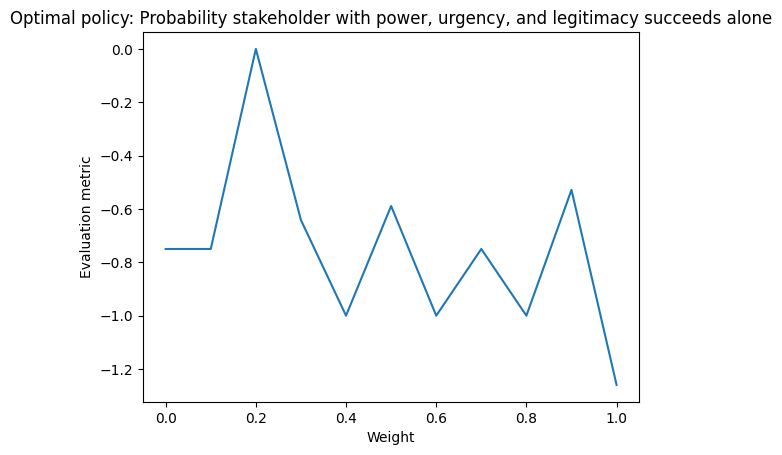

In [9]:
# normalize and plot
def minmax(lst):
    return (lst - np.min(lst)) / (np.max(lst) - np.min(lst))

normalized_steps = minmax(primary_steps)
eval_metric = -(normalized_steps / final_prob)

print("METRIC:",eval_metric)

def plot_metric(weights, eval_metric, weight_name):
    plt.plot(weights, eval_metric)
    plt.title(f"Optimal policy: {weight_name}")
    plt.xlabel("Weight")
    plt.ylabel("Evaluation metric")
    plt.show()

plot_metric(cur_weights, eval_metric, weight_name)

In [10]:
env = get_env(data)
obs, info = env.reset()
done = False
while not done:
    agent = env.env.agent_selection
    policy = policies[agent]
    action = policy.forward(batch=Batch(obs=[obs], info=[info])).act[0]

    recipient = f'agent_{action + 1}'
    print(f'{agent} targeting {recipient}')
    print(f'Actions: {env.env.agent_actions[agent]}')
    print(env.env.observe(None))
    print()
    
    obs, rew, done, truncated, info = env.step(action)
print('Final state:')
print(env.env.observe(None))
env.close()

agent_1 targeting agent_4
Actions: {'actions': []}
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

agent_2 targeting agent_3
Actions: {'actions': []}
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

agent_3 targeting agent_2
Actions: {'actions': []}
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

agent_4 targeting agent_2
Actions: {'actions': []}
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

agent_5 targeting agent_4
Actions: {'actions': []}
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

agent_1 targeting agent_4
Actions: {'actions': [3]}
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

agent_2 targeting agent_3
Actions: {'actions': [2]}
[[1 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 1 0]
 [0 0 0 0 1]]

agent_3 targeting agent_2
Actions: {'actions': [1]}
[[1 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 1 0]
 [0 0 0 0 1]]

agent_4 targeting agent_2
Actions: {'actions': [1]}
[

In [11]:
env.env.infos['agent_1']

{'metrics': [6, 0.7938614960486916]}

In [12]:
env.env.agent_actions['agent_1']

{'actions': [3, 3, 3, 3, 4, 4]}